# Study Experiment Design Generation

This notebook analyzes the characteristics of different space-filling experiment design generation techniques provide by raxpy for different input spaces.

In [1]:
from typing import NamedTuple, Callable, List, Tuple

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np

import raxpy
import raxpy.spaces.root as s
import raxpy.spaces.dimensions as d
import raxpy.spaces.complexity as c
import raxpy.does.lhs as lhs_doe
import raxpy.does.random as random_doe
import raxpy.does.assess as assess
from raxpy.does import plots
import raxpy.does.doe 
from raxpy.does.doe import EncodingEnum

import importlib

importlib.reload(raxpy.does.doe)

class DoeTuple(NamedTuple):
    design:lhs_doe.DesignOfExperiment
    assessment:assess.DoeAssessment

class DesignStrategyResults(NamedTuple):
    strategy:Callable
    name:str
    designs:List[DoeTuple]


## Create Helper Functions

In [2]:
def compute_sub_space_allocations(doe, sub_spaces):
    actual_counts = {sub_space:0 for sub_space in sub_spaces}

    # determine the sub-space each data-point belongs to
    def map_point(point):
        active_dim_ids = []

        for dim_id, column_index in doe.input_set_map.items():
            if ~np.isnan(point[column_index]):
                active_dim_ids.append(dim_id)

        active_dim_ids.sort()
        actual_counts[tuple(a for a in active_dim_ids)] += 1

    # compute the subspace each point belongs to
    for point in doe.decoded_input_sets:
        map_point(point)
    
    return actual_counts
        
def meets_portions(doe, expected_counts):
    actual_counts = compute_sub_space_allocations(doe,expected_counts.keys())

    for key in expected_counts.keys():
        if expected_counts[key] != actual_counts[key]:
            print(actual_counts)
            return False

    return True

def generate_designs(strategies:List[DesignStrategyResults], space: s.InputSpace, number_of_designs: int = 10, number_of_points: int = 100, target_full_sub_space_portions=None):
    for _, strategy in enumerate(strategies):
        print(f"Generating designs for strategy: '{strategy[1]}'")
        design_count = 0
        while design_count < number_of_designs:
            doe = strategy[0](space, number_of_points)

            if target_full_sub_space_portions is None or meets_portions(doe, target_full_sub_space_portions):
                # note that we use decoded values for assessment, 
                # This allows comparison with all stratgies since some 
                # generate designs in decoded space
                # All input spaces use floats with 0 to 1 bounds so 
                # dimensional range bias not an issue.
                assessment = assess.assess_with_all_metrics(doe, encoding=EncodingEnum.NONE)
                strategy[2].append(DoeTuple(doe,assessment))
                design_count += 1
                print(f"Created design {design_count} for {strategy[1]}")
            else:
                print("Skipping design")
            

In [3]:
def plot_fullsubspace_target_portions(space: s.InputSpace, number_of_points: int = 100):
    subspaces = space.derive_full_subspaces()
    
    values = c.compute_subspace_portions(space, subspaces)
    
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

    rects = axs.bar(x=list(i for i in range(len(subspaces))),height=values, tick_label=list(", ".join(subspace) for subspace in subspaces))

    axs.bar_label(rects, labels=list(f"{int(value*100)}% - {round(value*number_of_points)}" for value in values))

    axs.set_ylabel("Portion Percentage")

    axs.set_title(f'Target Portions for {number_of_points} points')
    plt.xticks(rotation=45)
    plt.show()

In [4]:

def dict_to_hashable_tuple(d):
    return tuple(sorted(d.items()))

class DesignAssessmentGroups:

    def __init__(self, space, strategy_names):
        self.design_allocations = {}
        self.space = space
        self.strategy_names = strategy_names
        self.sub_spaces = tuple(tuple(l) for l in space.derive_full_subspaces())

    def add_design(self,strategy_name, doe_tuple:DoeTuple):
        
        allocation = dict_to_hashable_tuple(
            compute_sub_space_allocations(doe_tuple.design, self.sub_spaces)
        )
        if allocation not in self.design_allocations:
            self.design_allocations[allocation] = {name:[] for name in self.strategy_names}

        self.design_allocations[allocation][strategy_name].append(doe_tuple)
    
    def print_allocation_counts(self):

        for full_sub_space, design_allocation in self.design_allocations.items():
            
            print(f"{full_sub_space} - {', '.join(str(len(d)) for d in design_allocation.values())}")

    def generate_allocation_point_differences(self, target_sub_space_allocations):
        count_differences = {name:[] for name in self.strategy_names}
        for full_sub_space, design_allocation in self.design_allocations.items():
            # compute point count differences from target

            diff = 0
            for sub_spaces, actual_count in full_sub_space:
                target_count = target_sub_space_allocations[sub_spaces]
                diff += abs(target_count - actual_count)

            diff = diff/2.0 # avoid double counting
            for strat_name, doe_tuples in design_allocation.items():
                for _ in range(len(doe_tuples)):
                    count_differences[strat_name].append(diff)
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

        axs.violinplot(list(v for v in count_differences.values()),
                        showmeans=False,
                        showmedians=True)
        axs.set_xticks(list(i+1 for i in range(len(self.strategy_names))))
        axs.set_xticklabels(self.strategy_names)

        axs.set_title(f'Allocation Point Count Differences from Target')

        plt.show()

def split_designs_by_subspace_allocations(strategies:List[DesignStrategyResults], space:s.InputSpace) -> DesignAssessmentGroups:

    
    assessment_group = DesignAssessmentGroups(space, strategy_names=list(s.name for s in strategies))

    
    for strategy in strategies:

        for design in strategy.designs:
            # determine the allocations to sub-spaces
            assessment_group.add_design(strategy.name, design)
    

    return assessment_group


In [5]:
def get_sub_space_assessments(strategies:List[DesignStrategyResults], dim_list, metric=assess.METRIC_DISCREPANCY):
    results = []
    for strategy in strategies:
        design_results = []
        for doe_tuple in strategy.designs:
            assessment = doe_tuple.assessment.get_full_sub_design_assessment(dim_list)
            if assessment is not None:
                if metric in assessment.measurements:
                    design_results.append(assessment.measurements[metric])
                else:
                    print(f"Skipping design for strategy '{strategy.name}' since it does not metric '{metric}' ")
        results.append(design_results)

    return results

In [6]:
def plot_sub_space_assessments(strategies:List[DesignStrategyResults], dim_list, metric=assess.METRIC_DISCREPANCY):
    assessment_values = get_sub_space_assessments(strategies, dim_list, metric)

    assessmentic_data = [[t for t in assessment_values[i] ] for i in range(len(strategies))]
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

    axs.violinplot(assessmentic_data,
                    showmeans=False,
                    showmedians=True)
    axs.set_xticks(list(i+1 for i in range(len(strategies))))
    axs.set_xticklabels(list(strategy.name for strategy in strategies))

    axs.set_title(f'{metric} for {", ".join(dim_list)} full-sub-design (smaller the better)')

    plt.show()
    pass

In [7]:
def generate_basic_plots(strategies:List[DesignStrategyResults]):
    
    assessmentic_data = [[t.assessment.measurements[assess.METRIC_WEIGHTED_DISCREPANCY] for t in strategy.designs ] for strategy in strategies]
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

    axs.violinplot(assessmentic_data,
                    showmeans=False,
                    showmedians=True)
    axs.set_title('Weighted Discrepancies (smaller the better)')
    axs.set_xticks(list(i+1 for i in range(len(strategies))))
    axs.set_xticklabels(list(strategy.name for strategy in strategies))

    plt.show()

    assessmentic_data = [[t.assessment.measurements[assess.METRIC_WHOLE_MIN_POINT_DISTANCE] for t in strategy.designs ] for strategy in strategies]
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

    axs.violinplot(assessmentic_data,
                    showmeans=False,
                    showmedians=True)
    axs.set_title('Minimum Interpoint Distances (larger the better)')
    axs.set_xticks(list(i+1 for i in range(len(strategies))))
    axs.set_xticklabels(list(strategy.name for strategy in strategies))

    plt.show()


    assessmentic_data = [[t.assessment.measurements[assess.METRIC_WHOLE_MIN_PROJECTED_DISTANCE] for t in strategy.designs ] for strategy in strategies]
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
    print(assessmentic_data)
    axs.violinplot(assessmentic_data,
                    showmeans=False,
                    showmedians=True)
    axs.set_title('Minimum Projected Distances (larger the better)')
    axs.set_xticks(list(i+1 for i in range(len(strategies))))
    axs.set_xticklabels(list(strategy.name for strategy in strategies))

    plt.show()

In [8]:
def peek_into_results(strategies:List[DesignStrategyResults]):

    for strategy in strategies:
        print("\n\n-----------------------------------")
        print(f"Strategy: {strategy.name}")
        doe_tuple = strategy.designs[0]
        print("-Example Design Peak-------------------")
        print(doe_tuple.design.decoded_input_sets[0:5,:])
        print("-Measurements-------------------")
        print(doe_tuple.assessment.measurements)
        print("-Sub-Design Assessments----------------")
        print(doe_tuple.assessment.full_sub_set_assessments)
        

# Assessment A: 3 Optional Floats

In [8]:
strategies = [
    DesignStrategyResults(lhs_doe.generate_design, "LHD-by-TreeTraversal",[]),
    DesignStrategyResults(lhs_doe.generate_seperate_designs_by_full_subspace_and_pool, "LHD-by-SubSpace-Projection",[]),
    DesignStrategyResults(random_doe.generate_design, "Random",[]),
    DesignStrategyResults(random_doe.generate_seperate_designs_by_full_subspace, "Random-by-SubSpace",[]),
    DesignStrategyResults(lhs_doe.generate_seperate_designs_by_full_subspace, "LHD-by-SubSpace",[]),
    DesignStrategyResults(lhs_doe.generate_design_with_projection, "LHD-Projection", []),
]

space = s.InputSpace(
    dimensions=[
        d.Float(id="x1", lb=0.0, ub=1.0, nullable=True, portion_null=0.1),
        d.Float(id="x2", lb=0.0, ub=1.0, nullable=True, portion_null=0.1),
        d.Float(id="x3", lb=0.0, ub=1.0, nullable=True, portion_null=0.1),
    ]
)

target_sub_space_allocations = {
    tuple():0,
    ("x1",):1,
    ("x2",):1,
    ("x3",):1,
    ("x1","x2"):8,
    ("x1","x3"):8,
    ("x2","x3"):8,
    ("x1","x2","x3"):73,
}


By default when creating dimensions, the target portion of values in a design to be null is unspecified. Creating a design without specifying these values, results in the whole design to have parameters. The following code assigns these portitions using a complexity analysis hueristic.

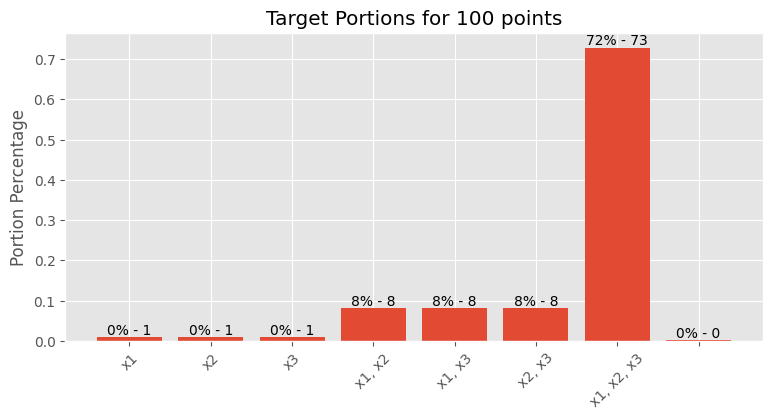

In [9]:
plot_fullsubspace_target_portions(space,number_of_points=100)

In [10]:
generate_designs(
    strategies, space, number_of_designs=1, 
)

Generating designs for strategy: 'LHD-by-TreeTraversal'
Created design 1 for LHD-by-TreeTraversal
Generating designs for strategy: 'Random'
Created design 1 for Random
Generating designs for strategy: 'Random-by-SubSpace'
Skipping dimensions
Created design 1 for Random-by-SubSpace
Generating designs for strategy: 'LHD-by-SubSpace'
Skipping dimensions
Created design 1 for LHD-by-SubSpace
Generating designs for strategy: 'LHD-Projection'
Created design 1 for LHD-Projection


(((), 0), (('x1',), 1), (('x1', 'x2'), 9), (('x1', 'x2', 'x3'), 72), (('x1', 'x3'), 8), (('x2',), 0), (('x2', 'x3'), 9), (('x3',), 1)) - 1, 0, 0, 0, 0
(((), 1), (('x1',), 0), (('x1', 'x2'), 4), (('x1', 'x2', 'x3'), 84), (('x1', 'x3'), 1), (('x2',), 3), (('x2', 'x3'), 5), (('x3',), 2)) - 0, 1, 0, 0, 0
(((), 0), (('x1',), 1), (('x1', 'x2'), 8), (('x1', 'x2', 'x3'), 73), (('x1', 'x3'), 8), (('x2',), 1), (('x2', 'x3'), 8), (('x3',), 1)) - 0, 0, 1, 1, 0
(((), 0), (('x1',), 0), (('x1', 'x2'), 10), (('x1', 'x2', 'x3'), 71), (('x1', 'x3'), 9), (('x2',), 0), (('x2', 'x3'), 9), (('x3',), 1)) - 0, 0, 0, 0, 1


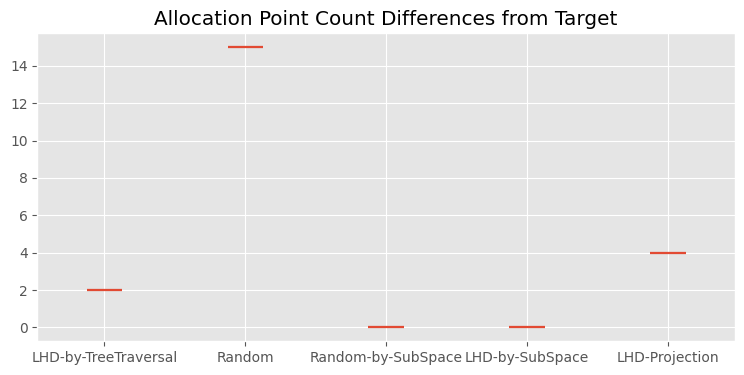

In [11]:
assessment_group = split_designs_by_subspace_allocations(strategies, space)
assessment_group.print_allocation_counts()
assessment_group.generate_allocation_point_differences(target_sub_space_allocations)

In [12]:
# now lets reset and analyze without random
strategies = [
    DesignStrategyResults(lhs_doe.generate_design, "LHD-by-TreeTraversal",[]),
    # DesignStrategyResults(random_doe.generate_design, "Random",[]),
    DesignStrategyResults(random_doe.generate_seperate_designs_by_full_subspace, "Random-by-SubSpace",[]),
    DesignStrategyResults(lhs_doe.generate_seperate_designs_by_full_subspace, "LHD-by-SubSpace",[]),
    DesignStrategyResults(lhs_doe.generate_design_with_projection, "LHD-Projection", []),
]
generate_designs(
    strategies, space, number_of_designs=10,
    target_full_sub_space_portions=target_sub_space_allocations
)

Generating designs for strategy: 'LHD-by-TreeTraversal'
{(): 0, ('x1',): 1, ('x2',): 0, ('x3',): 1, ('x1', 'x2'): 9, ('x1', 'x3'): 8, ('x2', 'x3'): 9, ('x1', 'x2', 'x3'): 72}
Skipping design
{(): 0, ('x1',): 1, ('x2',): 1, ('x3',): 2, ('x1', 'x2'): 8, ('x1', 'x3'): 7, ('x2', 'x3'): 7, ('x1', 'x2', 'x3'): 74}
Skipping design
Created design 1 for LHD-by-TreeTraversal
{(): 0, ('x1',): 1, ('x2',): 0, ('x3',): 1, ('x1', 'x2'): 9, ('x1', 'x3'): 8, ('x2', 'x3'): 9, ('x1', 'x2', 'x3'): 72}
Skipping design
{(): 0, ('x1',): 1, ('x2',): 0, ('x3',): 1, ('x1', 'x2'): 9, ('x1', 'x3'): 8, ('x2', 'x3'): 9, ('x1', 'x2', 'x3'): 72}
Skipping design
Created design 2 for LHD-by-TreeTraversal
{(): 0, ('x1',): 1, ('x2',): 1, ('x3',): 2, ('x1', 'x2'): 8, ('x1', 'x3'): 7, ('x2', 'x3'): 7, ('x1', 'x2', 'x3'): 74}
Skipping design
{(): 0, ('x1',): 1, ('x2',): 0, ('x3',): 0, ('x1', 'x2'): 9, ('x1', 'x3'): 9, ('x2', 'x3'): 10, ('x1', 'x2', 'x3'): 71}
Skipping design
{(): 0, ('x1',): 1, ('x2',): 1, ('x3',): 0, ('x1'

In [13]:
strategies[0].designs[0].design.input_sets

array([[0.745, 0.175, 0.475],
       [0.105, 0.675, 0.515],
       [0.735, 0.365, 0.155],
       [0.685, 0.595, 0.095],
       [0.365, 0.025, 0.135],
       [0.355, 0.415, 0.635],
       [0.775, 0.505, 0.405],
       [0.525, 0.375, 0.735],
       [0.925, 0.145, 0.185],
       [0.965, 0.645, 0.065],
       [0.115, 0.225, 0.795],
       [0.065, 0.785, 0.425],
       [0.215, 0.015, 0.295],
       [0.035, 0.105, 0.575],
       [0.095, 0.945, 0.945],
       [0.075, 0.035, 0.725],
       [0.385, 0.385, 0.535],
       [0.695, 0.885, 0.335],
       [0.815, 0.005, 0.305],
       [0.475, 0.165, 0.085],
       [0.045, 0.545, 0.165],
       [0.265, 0.735, 0.125],
       [0.795, 0.475, 0.035],
       [0.785, 0.695, 0.545],
       [0.565, 0.935, 0.285],
       [0.455, 0.075, 0.385],
       [0.145, 0.605, 0.605],
       [0.395, 0.715, 0.375],
       [0.905, 0.925, 0.565],
       [0.885, 0.525, 0.585],
       [0.335, 0.065, 0.645],
       [0.005, 0.315, 0.885],
       [0.665, 0.555, 0.315],
       [0.

In [14]:
strategies[0].designs[0].design.decoded_input_sets

array([[0.71666667, 0.08333333, 0.41666667],
       [0.00555556, 0.63888889, 0.46111111],
       [0.70555556, 0.29444444, 0.06111111],
       [0.65      , 0.55      ,        nan],
       [0.29444444,        nan, 0.03888889],
       [0.28333333, 0.35      , 0.59444444],
       [0.75      , 0.45      , 0.33888889],
       [0.47222222, 0.30555556, 0.70555556],
       [0.91666667, 0.05      , 0.09444444],
       [0.96111111, 0.60555556,        nan],
       [0.01666667, 0.13888889, 0.77222222],
       [       nan, 0.76111111, 0.36111111],
       [0.12777778,        nan, 0.21666667],
       [       nan, 0.00555556, 0.52777778],
       [       nan, 0.93888889, 0.93888889],
       [       nan,        nan, 0.69444444],
       [0.31666667, 0.31666667, 0.48333333],
       [0.66111111, 0.87222222, 0.26111111],
       [0.79444444,        nan, 0.22777778],
       [0.41666667, 0.07222222,        nan],
       [       nan, 0.49444444, 0.07222222],
       [0.18333333, 0.70555556, 0.02777778],
       [0.

In [15]:
strategies[0].designs[0].assessment.full_sub_set_assessments

[FullSubDesignAssessment(point_count=1, active_dimensions=['x1'], measurements={'discrepancy': 0.08336419753086433, 'portion_of_total': 0.01, 'avg_portion_of_levels_included': None}, space_attributes=set()),
 FullSubDesignAssessment(point_count=1, active_dimensions=['x2'], measurements={'discrepancy': 0.18361111111111117, 'portion_of_total': 0.01, 'avg_portion_of_levels_included': None}, space_attributes=set()),
 FullSubDesignAssessment(point_count=1, active_dimensions=['x3'], measurements={'discrepancy': 0.12114197530864179, 'portion_of_total': 0.01, 'avg_portion_of_levels_included': None}, space_attributes=set()),
 FullSubDesignAssessment(point_count=8, active_dimensions=['x1', 'x2'], measurements={'discrepancy': 0.015652085238530677, 'portion_of_total': 0.08, 'avg_portion_of_levels_included': None, 'max_min_point_distance': np.float64(0.18087578440110783)}, space_attributes=set()),
 FullSubDesignAssessment(point_count=8, active_dimensions=['x1', 'x3'], measurements={'discrepancy': 0

In [16]:
strategies[0].designs[0].assessment.measurements

{'weighted_discrepancy': 0.00815669247517364,
 'weighted_mipd': np.float64(0.10419425538247072),
 'max_whole_min_point_distance': np.float64(0.08958064164776158),
 'max_whole_min_projected_distance': np.float64(0.01111111111111096)}

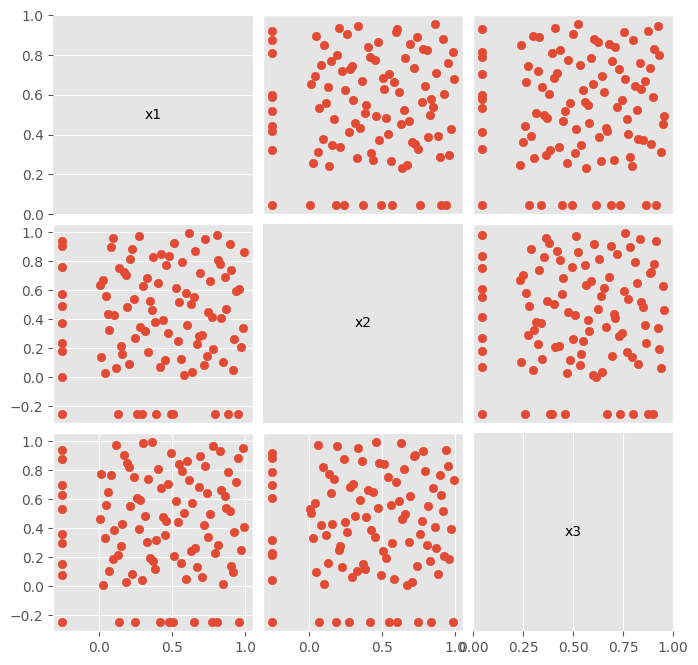

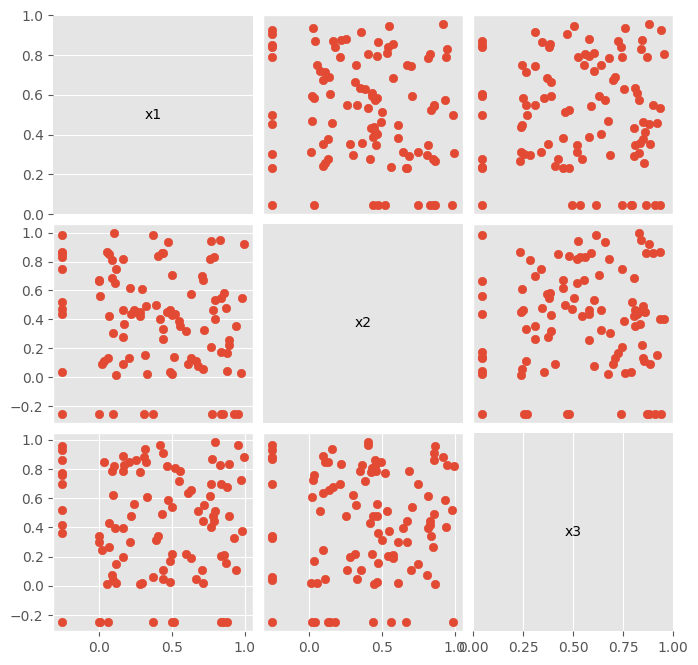

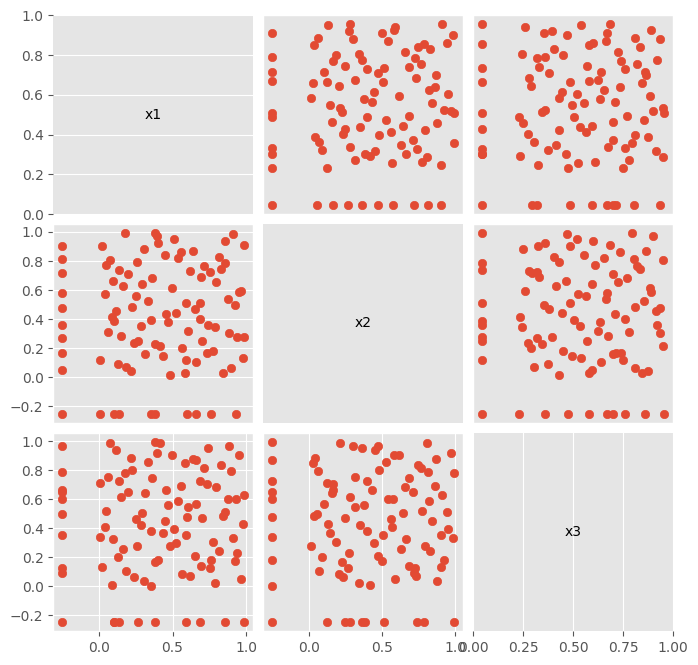

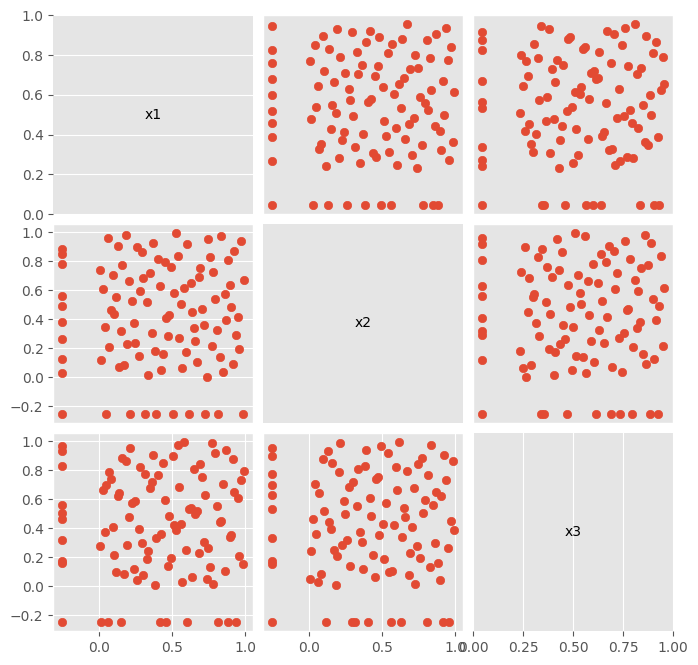

In [17]:
f1 = plots.scatterplot_matrix(strategies[0].designs[0].design.decoded_input_sets, ["x1", "x2", "x3"])
f2 = plots.scatterplot_matrix(strategies[1].designs[0].design.decoded_input_sets, ["x1", "x2", "x3"])
f3 = plots.scatterplot_matrix(strategies[2].designs[0].design.decoded_input_sets, ["x1", "x2", "x3"])
f4 = plots.scatterplot_matrix(strategies[3].designs[0].design.decoded_input_sets, ["x1", "x2", "x3"])

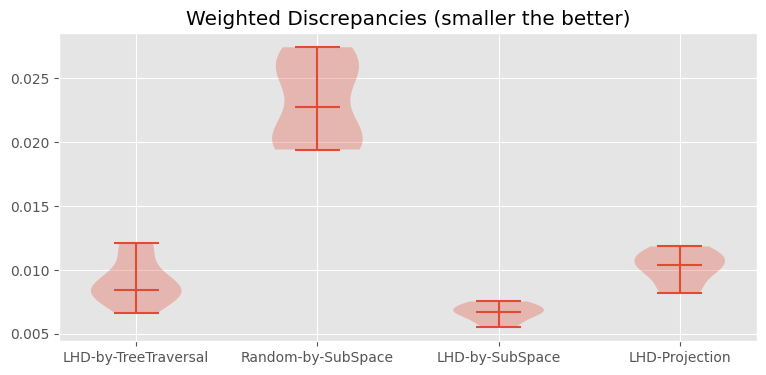

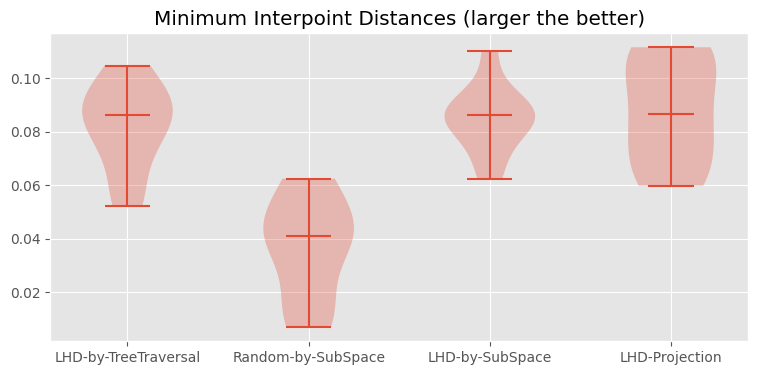

[[np.float64(0.01111111111111096), np.float64(0.01111111111111096), np.float64(0.01111111111111096), np.float64(0.01111111111111096), np.float64(0.01111111111111096), np.float64(0.01111111111111096), np.float64(0.01111111111111096), np.float64(0.01111111111111096), np.float64(0.01111111111111096), np.float64(0.01111111111111096)], [np.float64(1.416385394525932e-07), np.float64(3.493787776287505e-05), np.float64(0.0002564555802631041), np.float64(2.3411393557104532e-05), np.float64(9.206382545423608e-06), np.float64(3.123836367324717e-05), np.float64(0.00010623585539981661), np.float64(1.9852167228218143e-05), np.float64(1.4601475214814919e-05), np.float64(8.49988398721191e-06)], [np.float64(0.00015011510495976932), np.float64(2.6755955757629124e-05), np.float64(4.459679188140164e-05), np.float64(1.6164354791792235e-05), np.float64(1.4445749605573877e-05), np.float64(5.876730846704481e-05), np.float64(5.797580924832291e-05), np.float64(0.0002592314795441808), np.float64(0.00016276801482

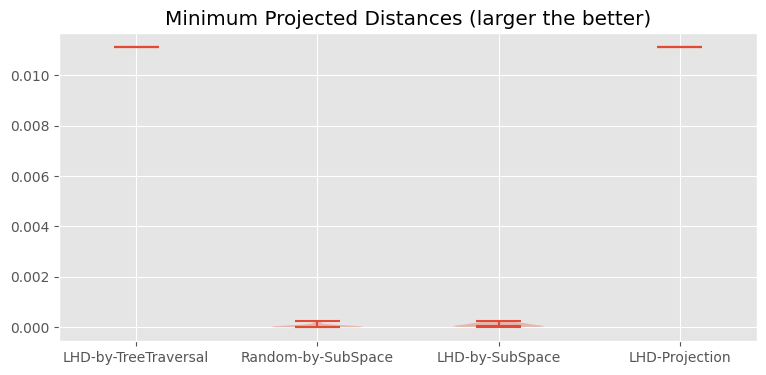

In [18]:
generate_basic_plots(strategies)

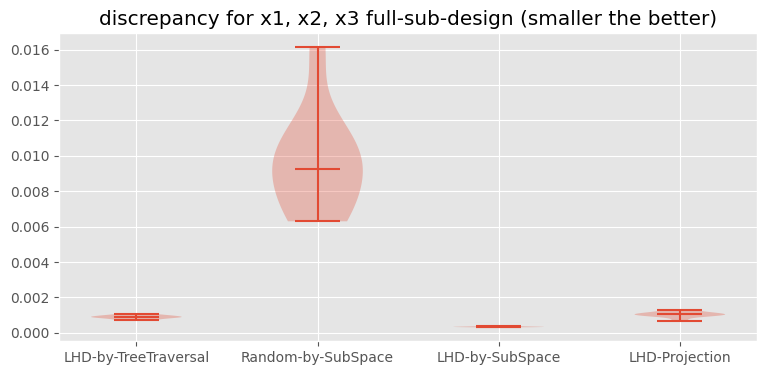

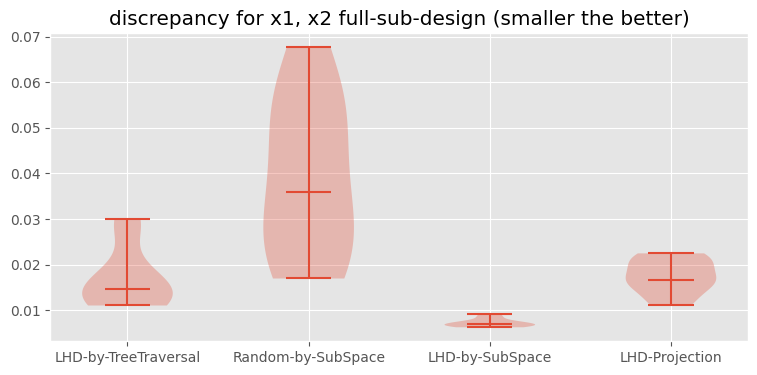

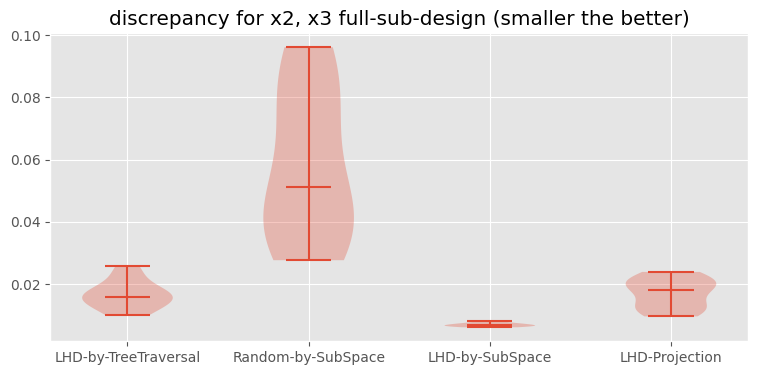

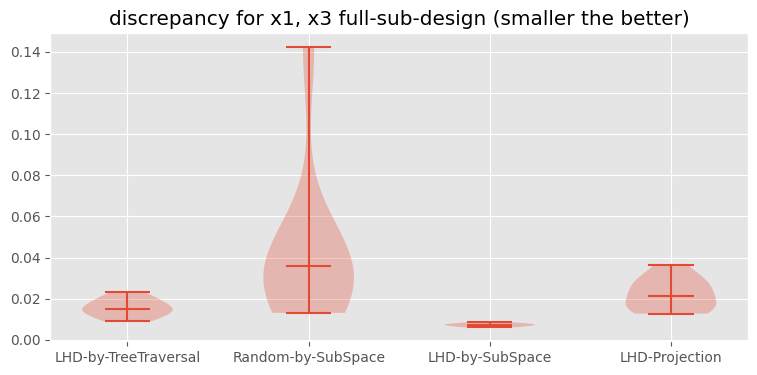

In [19]:
# custom assessment plots
plot_sub_space_assessments(strategies, ("x1","x2","x3"), assess.METRIC_DISCREPANCY)
plot_sub_space_assessments(strategies, ("x1","x2"), assess.METRIC_DISCREPANCY)
plot_sub_space_assessments(strategies, ["x2","x3"], assess.METRIC_DISCREPANCY)
plot_sub_space_assessments(strategies, ["x1","x3"], assess.METRIC_DISCREPANCY)

# Assessment B: Basic Heirarchy

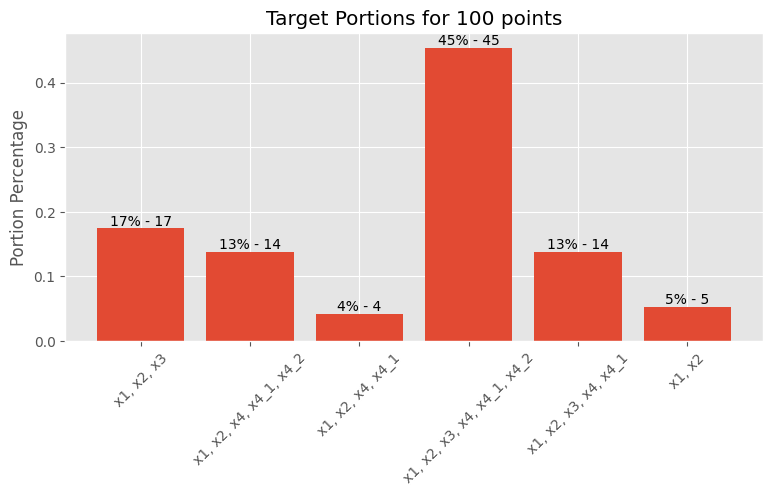

In [20]:
strategies_bh = [
    DesignStrategyResults(lhs_doe.generate_design, "LHD-by-TreeTraversal",[]),
    DesignStrategyResults(lhs_doe.generate_design_merge_simple, "LHD-by-TreeTraversal(Simple)",[]),
    #DesignStrategyResults(random_doe.generate_design, "Random",[]),
    
    DesignStrategyResults(random_doe.generate_seperate_designs_by_full_subspace, "Random-by-SubSpace",[]),
    DesignStrategyResults(lhs_doe.generate_seperate_designs_by_full_subspace, "LHD-by-SubSpace",[]),
    DesignStrategyResults(lhs_doe.generate_design_with_projection, "LHD-Projection", []),
]

space_bh = s.InputSpace(
    dimensions=[
        d.Float(id="x1", lb=0.0, ub=1.0, nullable=False),
        d.Float(id="x2", lb=0.0, ub=1.0, nullable=False),
        d.Float(id="x3", lb=0.0, ub=1.0, nullable=True),
        d.Composite(id="x4", nullable=True, children=[
            d.Float(id="x4_1", lb=0.0, ub=1.0, nullable=False),
            d.Float(id="x4_2", lb=0.0, ub=1.0, nullable=True),
        ])
    ]
)

c.assign_null_portions(s.create_level_iterable(space_bh.children))
number_of_points = 100
plot_fullsubspace_target_portions(space_bh,number_of_points)

target_full_sub_space_portions_bh={
    ("x1","x2","x3"):17,
    ("x1","x2","x4","x4_1","x4_2"):14,
    ("x1","x2","x4","x4_1"):5,
    ("x1","x2","x3","x4","x4_1","x4_2"):45,
    ("x1","x2","x3","x4","x4_1"):14,
    ("x1","x2"):5
}

In [21]:
generate_designs(
    strategies_bh,
    space_bh,
    number_of_designs=10,
    number_of_points=number_of_points,
)

Generating designs for strategy: 'LHD-by-TreeTraversal'
Created design 1 for LHD-by-TreeTraversal
Created design 2 for LHD-by-TreeTraversal
Created design 3 for LHD-by-TreeTraversal
Created design 4 for LHD-by-TreeTraversal
Created design 5 for LHD-by-TreeTraversal
Created design 6 for LHD-by-TreeTraversal
Created design 7 for LHD-by-TreeTraversal
Created design 8 for LHD-by-TreeTraversal
Created design 9 for LHD-by-TreeTraversal
Created design 10 for LHD-by-TreeTraversal
Generating designs for strategy: 'LHD-by-TreeTraversal(Simple)'
Created design 1 for LHD-by-TreeTraversal(Simple)
Created design 2 for LHD-by-TreeTraversal(Simple)
Created design 3 for LHD-by-TreeTraversal(Simple)
Created design 4 for LHD-by-TreeTraversal(Simple)
Created design 5 for LHD-by-TreeTraversal(Simple)
Created design 6 for LHD-by-TreeTraversal(Simple)
Created design 7 for LHD-by-TreeTraversal(Simple)
Created design 8 for LHD-by-TreeTraversal(Simple)
Created design 9 for LHD-by-TreeTraversal(Simple)
Created d

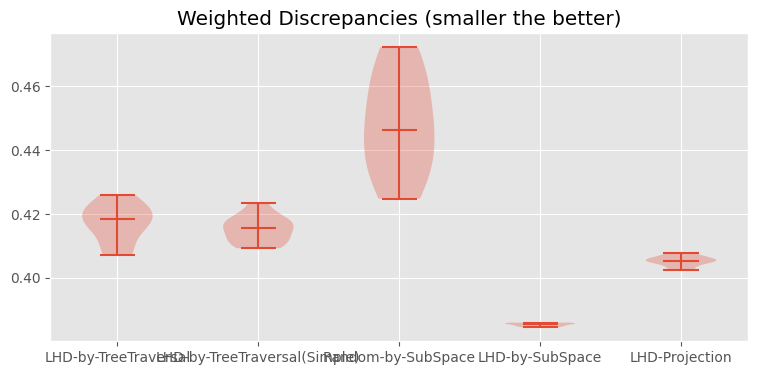

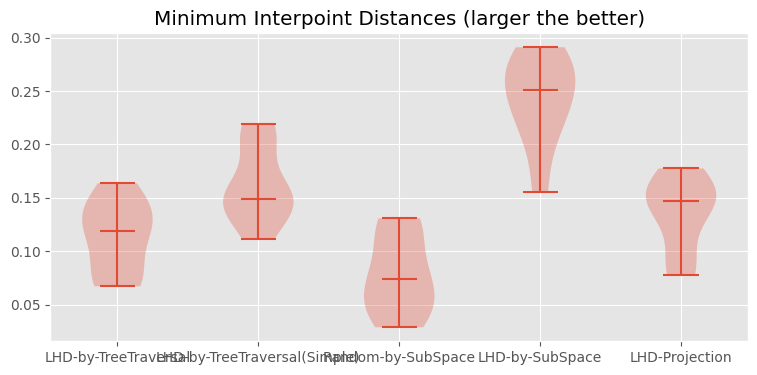

[[np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898)], [np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898)], [np.float64(3.063605709774375e-05), np.float64(1.5897809742426716e-05), np.float64(2.6070376180964416e-05), np.float64(3.250480854177784e-05), np.float64(2.837901780661234e-05), np.float64(6.423084821793879e-07), np.float64(1.0818263758261004e-05), np.float64(3.0674333516333974e-05), np.float64(2.838370748969865e-

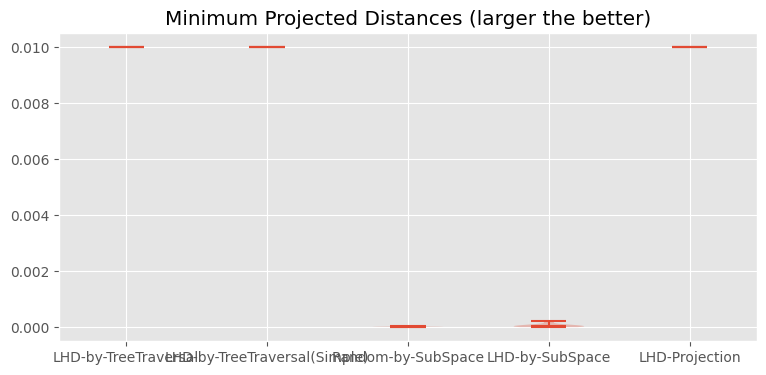

In [22]:
generate_basic_plots(strategies_bh)

# Assessment C: More complex hierarchy

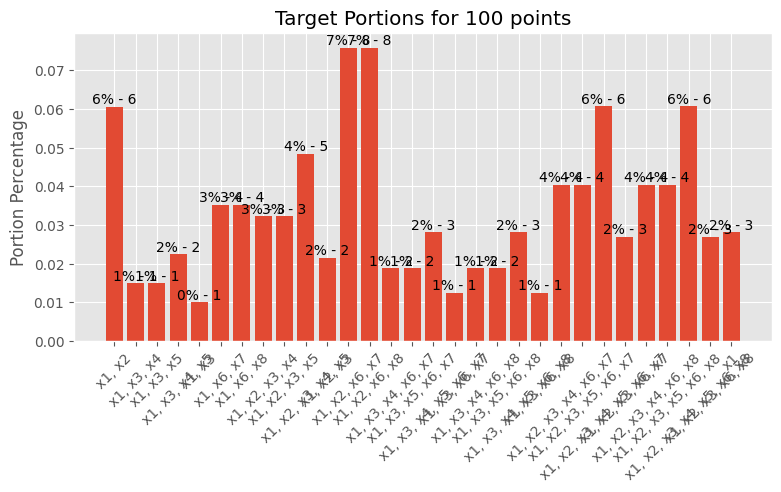

In [28]:

strategies_ch = [
    DesignStrategyResults(lhs_doe.generate_design, "LHD-by-TreeTraversal",[]),
    DesignStrategyResults(random_doe.generate_design, "Random",[]),
    DesignStrategyResults(lhs_doe.generate_seperate_designs_by_full_subspace, "LHD-by-SubSpace",[]),
    DesignStrategyResults(lhs_doe.generate_design_with_projection, "LHD-Projection", []),
]

space_ch = s.InputSpace(
    dimensions=[
        d.Float(id="x1", lb=0.0, ub=1.0),
        d.Float(
            id="x2",
            lb=0.0,
            ub=1.0,
            nullable=True,
            portion_null=1.0 / 10.0,
        ),
        d.Composite(
            id="x3",
            nullable=True,
            portion_null=1.0 / 7.0,
            children=[
                d.Float(
                    id="x4",
                    lb=0.0,
                    ub=1.0,
                    nullable=True,
                    portion_null=1.0 / 10.0,
                ),
                d.Float(
                    id="x5",
                    lb=0.0,
                    ub=1.0,
                    nullable=True,
                    portion_null=1.0 / 10.0,
                ),
            ],
        ),
        d.Variant(
            id="x6",
            nullable=True,
            portion_null=0.33,
            options=[
                d.Float(id="x7", lb=0.0, ub=1.0),
                d.Float(id="x8", lb=0.0, ub=1.0),
            ],
        ),
    ]
)

c.assign_null_portions(s.create_level_iterable(space_ch.children))
plot_fullsubspace_target_portions(space_ch)

In [29]:
generate_designs(
    strategies_ch,
    space_ch,
    number_of_designs=100,
    number_of_points=number_of_points,
)

Generating designs for strategy: 'LHD-by-TreeTraversal'
Created design 1 for LHD-by-TreeTraversal
Created design 2 for LHD-by-TreeTraversal
Created design 3 for LHD-by-TreeTraversal
Created design 4 for LHD-by-TreeTraversal
Created design 5 for LHD-by-TreeTraversal
Created design 6 for LHD-by-TreeTraversal
Created design 7 for LHD-by-TreeTraversal
Created design 8 for LHD-by-TreeTraversal
Created design 9 for LHD-by-TreeTraversal
Created design 10 for LHD-by-TreeTraversal
Created design 11 for LHD-by-TreeTraversal
Created design 12 for LHD-by-TreeTraversal
Created design 13 for LHD-by-TreeTraversal
Created design 14 for LHD-by-TreeTraversal
Created design 15 for LHD-by-TreeTraversal
Created design 16 for LHD-by-TreeTraversal
Created design 17 for LHD-by-TreeTraversal
Created design 18 for LHD-by-TreeTraversal
Created design 19 for LHD-by-TreeTraversal
Created design 20 for LHD-by-TreeTraversal
Created design 21 for LHD-by-TreeTraversal
Created design 22 for LHD-by-TreeTraversal
Created

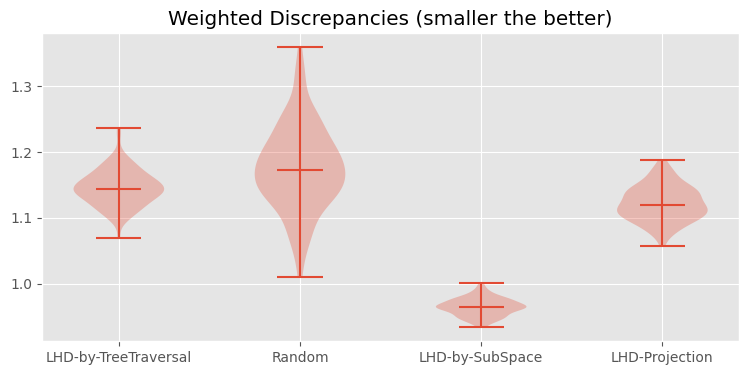

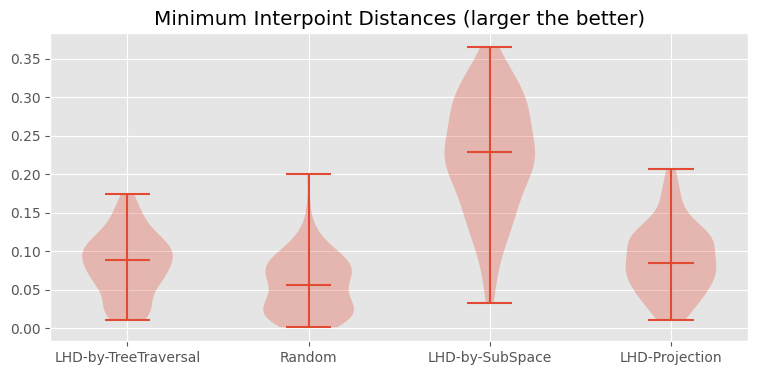

[[np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0.009999999999999898), np.float64(0

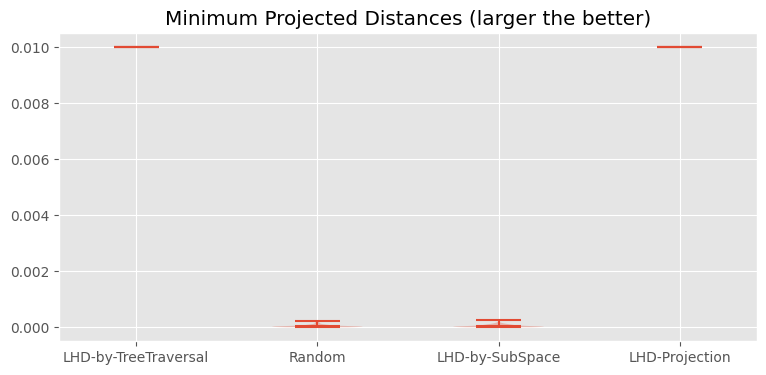

In [30]:
generate_basic_plots(strategies_ch)

In [27]:
peek_into_results(strategies_ch)



-----------------------------------
Strategy: LHD-by-TreeTraversal
-Example Design Peak-------------------
[[ 4.11       -4.45853659         nan  0.                 nan         nan
   1.27142857         nan]
 [ 3.43       -3.25853659         nan  1.                 nan         nan
          nan  3.45833333]
 [ 4.09               nan         nan         nan         nan         nan
          nan         nan]
 [ 4.89       -4.34146341  1.          1.          6.          0.1
          nan  3.40277778]
 [ 3.33               nan  1.          0.          7.          0.1
   1.18571429         nan]]
-Measurements-------------------
{'weighted_discrepancy': 0, 'weighted_mipd': np.float64(0.5059890884015158), 'max_whole_min_point_distance': np.float64(0.020000000000000018), 'max_whole_min_projected_distance': np.float64(0.0)}
-Sub-Design Assessments----------------
[FullSubDesignAssessment(point_count=8, active_dimensions=['x1', 'x2'], measurements={'portion_of_total': 0.08, 'avg_portion_of_le

In [ ]:
from scipy.stats.qmc import discrepancy

In [ ]:
discrepancy([[0.0],[0.5],[1.0]],method="WD")

In [ ]:
discrepancy([[0.0],[0.1],[1.0]],method="WD")

In [ ]:
discrepancy([[0.0],[0.001],[1.0]],method="WD")

In [ ]:
discrepancy([[0.0],[0.1],[0.05]],method="WD")

In [ ]:
discrepancy([[0.0],[0.1],[0.2],[0.3],[0.4],[0.5]],method="WD")

In [ ]:
discrepancy([[0.0],[0.19],[0.2],[0.3],[0.4],[0.5]],method="WD")

In [ ]:
discrepancy([[0.0],[0.19],[0.2],[0.21],[0.4],[0.5]],method="WD")

In [ ]:
discrepancy([[0.0],[0.19],[0.2],[0.21],[0.49],[0.5]],method="WD")

In [ ]:
discrepancy([[0.0],[0.01],[0.2],[0.21],[0.49],[0.5]],method="WD")

In [ ]:
help(discrepancy)

In [ ]:
discrepancy([[0.0],[0.19],[0.2],[0.21],[0.49],[0.5]], method="CD")

In [ ]:
discrepancy([[0.0],[0.1],[0.2],[0.3],[0.4],[0.5]], method="CD")